# Componentes del grupo:
*   Estela Pinto Requejo
*   Nicolás Felipe Trujillo Montero
*   Fco. Javier Cantón Correa

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---


En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [35]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import pandas as pd
from sklearn.metrics import precision_score, recall_score



In [36]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [37]:
# Descomprimimos el archivo en tmp para visualizar
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /tmp


In [38]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [39]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [40]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [41]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [42]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

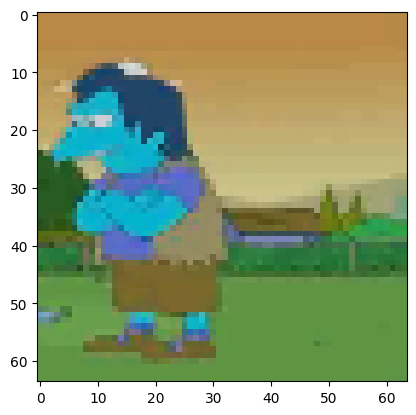

In [43]:
plt.imshow(X_t[2]) # recordad que siempre es preferible trabajar en blanco y negro

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## Informe

## Preprocesado: normalización y split

In [44]:
from sklearn.model_selection import train_test_split

# normalizamos las variables a utilizar
X_norm = X / 255 # este es el set que usaremos para training y test
X_t_norm = X_t / 255 # este es el set que usaremos para validation

# split de los datos 80% training y 20% test ya normalizados
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")
print(f"No. of training labels: {y_train.shape[0]}")
print(f"No. of testing labesl: {y_test.shape[0]}")

No. of training examples: 15193
No. of testing examples: 3799
No. of training labels: 15193
No. of testing labesl: 3799


## Implementación de modelo clásico ANN (1/2)

In [45]:
import matplotlib.pyplot as plt

# funciones auxiliares genericas para abstracion de codigo para la futura creacion y analisis de varios modelos clasicos
def createModel():
  """
    Funcion que crea el modelo de keras secuencial
    Returns: 
      model: El modelo creado
  """
  # definicion del modelo
  model = keras.models.Sequential()
  # primera capa transforma de una matriz a un vector, definimos el tamano de las imagenes
  model.add(keras.layers.Flatten(input_shape = [64, 64, 3]))
  # capas hidden de tamano 512 con sigmoid e init GlorotUniform
  model.add(keras.layers.Dense(512, activation = "sigmoid", kernel_initializer = tf.keras.initializers.GlorotUniform()))
  model.add(keras.layers.Dropout(0.4))
  model.add(keras.layers.Dense(512, activation = "sigmoid", kernel_initializer = tf.keras.initializers.GlorotUniform()))
  # capa de salida con solftmax para clasificacion y 18 etiquetas por lo tanto 18 neuronas
  model.add(keras.layers.Dense(18, activation = "softmax"))
  return model

def compileModel(innerModel): 
  """
    Funcion que compila el modelo creado
    Args:
      innerModel: modelo anteriormente creado con la funcion createModel()
  """  
  opt = keras.optimizers.Adam()
  innerModel.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer = opt, 
    metrics="accuracy"
  )

def fitModel(innerModel, innerEpochs, innerCallbacks):
  """
    Funcion que entrena el modelo creado y compilado
    Args:
      innerModel: modelo anteriormente creado con la createModel y compilado con compileModel
      innerEpochs: number of epochs
      innerCallbacks: custom callback para parar entrenamiento si cumple condicion
    Returns: 
      history: history object con todos los logs del entrenamiento
  """ 
  history = innerModel.fit(
    X_train, 
    y_train, 
    epochs = innerEpochs,
    batch_size = 64,
    validation_data = (X_test, y_test),
    callbacks = [innerCallbacks]
  )
  return history

def visualiseData(innerHistory):
  """
    Funcion que visualiza los datos de accuracy y lost, training and test data
    Args:
      innerHistory: objeto history devuelto de la funcion fitModel
  """
  # summarize history for accuracy
  plt.plot(innerHistory.history['accuracy'])
  plt.plot(innerHistory.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(innerHistory.history['loss'])
  plt.plot(innerHistory.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# creamos un callback para evitar el overfitting, cuando tengamos un 20% de loss con nuestro entrenamiento paramos
# asi evitaremos que memorice demasiado bien los datos del entrenamiento
class customEarlyStopCallback(tf.keras.callbacks.Callback):
  """ custom callback for loss <= 20% """
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') <= 0.20):
      print("\nAlcanzado el 20% de loss, se cancela el entrenamiento!!")
      self.model.stop_training = True

# creamos un callback para evitar el overfitting, cuando consigamos un 96% con nuestro entrenamiento paramos
# asi evitaremos que memorice demasiado bien los datos del entrenamiento
class customEarlyStopCallbackAccuracy(tf.keras.callbacks.Callback):
  """ custom callback for loss <= 96% """
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.96):
      print("\nAlcanzado el 96% de loss, se cancela el entrenamiento!!")
      self.model.stop_training = True


## Implementación de modelo clásico ANN (2/2)

In [46]:
# Actual model implementation reusando las funciones anteriormente definidas
callbacks = customEarlyStopCallback()
classic_model = createModel()
classic_model.summary()
compileModel(classic_model)
classic_history = fitModel(classic_model, 100, callbacks)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               6291968   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 18)                9234      
                                                                 
Total params: 6,563,858
Trainable params: 6,563,858
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
238/238 [=======================

## Evaluación de modelo clásico ANN

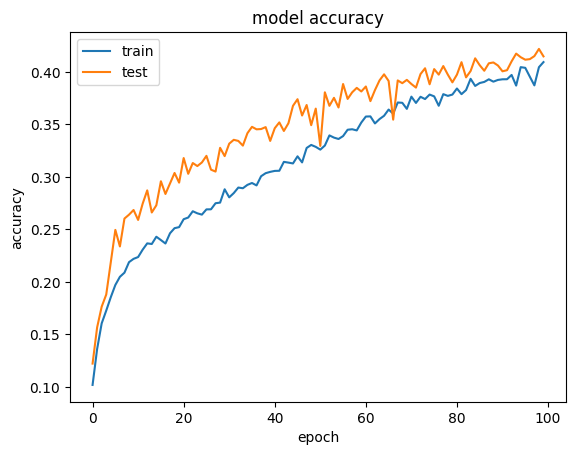

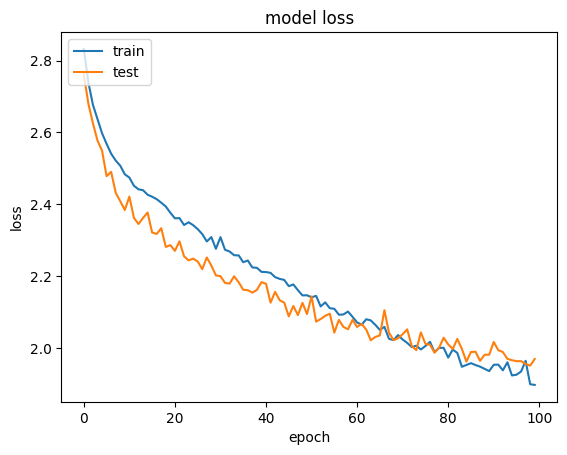

Evaluacion del modelo clasico:
28/28 [==============================] - 0s 3ms/step - loss: 1.8198 - accuracy: 0.4517


[1.8198314905166626, 0.4516853988170624]

In [47]:
visualiseData(classic_history)
print("Evaluacion del modelo clasico:")
classic_model.evaluate(X_test, y_test) # evaluamos con el conjunto de datos de test
classic_model.evaluate(X_t_norm, y_t) # evaluamos con el conjunto de datos de evaluacion inicial

## Implementación de modelo convolucional CNN funciones auxiliares

In [48]:
# reescribimos y_train, y_test para que tengan dimension (number_of_samples, 18), siendo 18 el numbero de clases
# asi evitamos ValueError: Shapes (None, 1) and (None, 18) are incompatible
# y_train_cnn = keras.utils.to_categorical(y_train, 18)
# y_test_cnn = keras.utils.to_categorical(y_test, 18)

# funciones auxiliares genericas para abstracion de codigo para la futura creacion y analisis de varios modelos convolucionales
def createCNNModel():
  """
    Funcion que crea el modelo de keras secuencial convolucional
    Returns: 
      model: El modelo creado
  """
  # definicion del modelo
  model = keras.models.Sequential()
  # Note the input shape is the desired size of the image 64x64 with 3 bytes color
  # This is the first convolution
  model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  model.add(keras.layers.MaxPooling2D(2, 2))
  # The second convolution
  model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
  model.add(keras.layers.MaxPooling2D(2, 2))
  # The third convolution
  model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(keras.layers.MaxPooling2D(2,2))
  # The fourth convolution
  model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
  model.add(keras.layers.MaxPooling2D(2,2))
  # Flatten the results to feed into a DNN
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.4))
  # 512 neuron hidden layer con 18 neuronas de salida por las 18 clases para clasificacion
  model.add(keras.layers.Dense(512, activation='relu'))
  model.add(keras.layers.Dense(18, activation='softmax'))
  return model

def compileCNNModel(innerModel): 
  """
    Funcion que compila el modelo convolucional creado
    Args:
      innerModel: modelo anteriormente creado con la funcion createCNNModel()
  """  
  innerModel.compile(
    loss = 'categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
  )

def fitCNNModel(innerModel, innerEpochs, innerCallbacks):
  """
    Funcion que entrena el modelo convolucional creado y compilado
    Args:
      innerModel: modelo anteriormente creado con la createCNNModel y compilado con compileCNNModel
      innerEpochs: number of epochs
      innerCallbacks: custom callback para parar entrenamiento si cumple condicion
    Returns: 
      history: history object con todos los logs del entrenamiento
  """ 
  history = innerModel.fit(
    X_train, 
    keras.utils.to_categorical(y_train, 18), 
    epochs = innerEpochs,
    batch_size = 64,
    validation_data = (X_test, keras.utils.to_categorical(y_test, 18)),
    callbacks = [innerCallbacks]
  )
  return history


## Implementación de modelo convolucional CNN sin data augmentation

In [49]:
# Actual model implementation reusando las funciones anteriormente definidas
callbacks = customEarlyStopCallbackAccuracy()
cnn_model = createCNNModel()
cnn_model.summary()
compileCNNModel(cnn_model)
cnn_history = fitCNNModel(cnn_model, 30, callbacks)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 128)       

## Evaluación de modelo convolucional CNN sin data augmentation

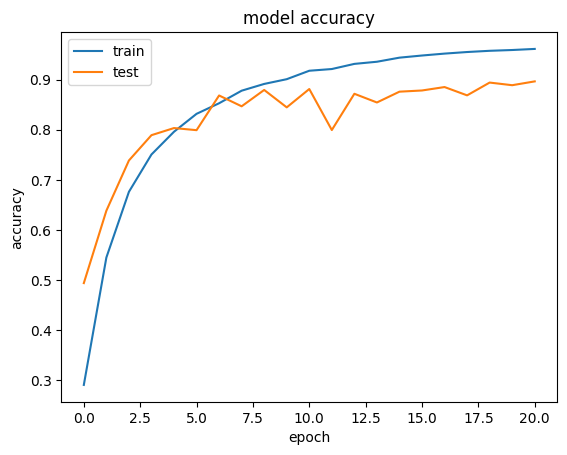

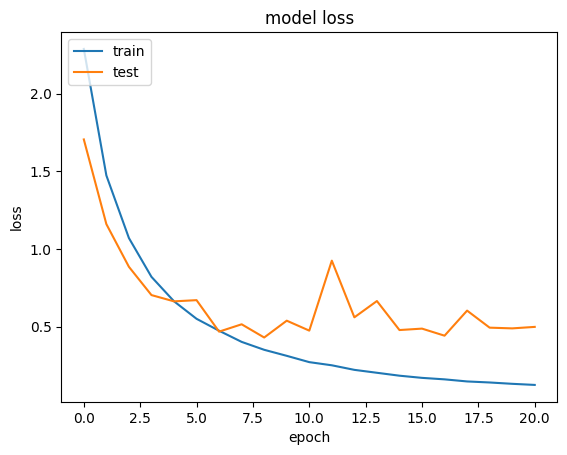

Evaluacion del modelo convolucional con datos de test desde slip:
119/119 [==============================] - 1s 6ms/step - loss: 0.4981 - accuracy: 0.8966
Evaluacion del modelo convolucional con datos de evaluation iniciales:
28/28 [==============================] - 0s 4ms/step - loss: 0.1373 - accuracy: 0.9663


[0.1372956484556198, 0.966292142868042]

In [50]:
visualiseData(cnn_history)
print("Evaluacion del modelo convolucional con datos de test desde slip:")
cnn_model.evaluate(X_test, keras.utils.to_categorical(y_test, 18)) # evaluamos con el conjunto de datos de test
print("Evaluacion del modelo convolucional con datos de evaluation iniciales:")
cnn_model.evaluate(X_t_norm, keras.utils.to_categorical(y_t, 18)) # evaluamos con el conjunto de datos de evaluacion inicial


## Análisis de los datos a utilizar

14
ned_flanders
(15193, 64, 64, 3)
'Training data' tiene: 15193 imagenes de tamaño 64x64x3
'Test data' tiene: 3799 imagenes de tamaño 64x64x3


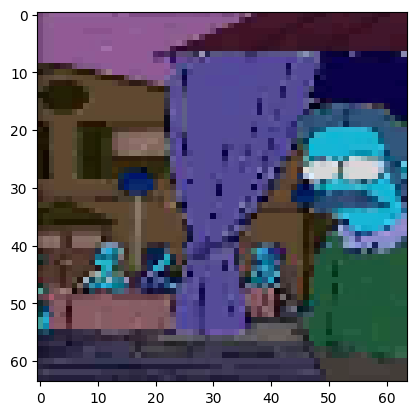

In [51]:
# X, y => total data
# X_t, y_t => data for evaluation
# X_norm => total data normalizado
# X_train, y_train => train data (80% del total data)
# X_test, y_test => test data (20% del total data)
indExample = 0
print(y_train[indExample])
print(MAP_CHARACTERS[y_train[indExample]])
plt.imshow(X_train[indExample], cmap="gray") # trabajamos en blanco y negro

# Usamos la funcion shape para ver la estructura e informacion de los datos
trainingShape = X_train.shape
testShape = X_test.shape
print(trainingShape)
print("'Training data' tiene: " + str(trainingShape[0]) + " imagenes de tamaño " + str(trainingShape[1]) + "x" + str(trainingShape[2]) + "x" + str(trainingShape[3]))
print("'Test data' tiene: " + str(testShape[0]) + " imagenes de tamaño " + str(testShape[1]) + "x" + str(testShape[2]) + "x" + str(testShape[3]))


In [52]:
# Exploración de las variables
print("Tamaño del conjunto de entrenamiento (imágenes):", X_train.shape)
print("Tamaño del conjunto de prueba (imágenes):", X_test.shape)
print("Tipo de datos de las imágenes:", X_train.dtype)

Tamaño del conjunto de entrenamiento (imágenes): (15193, 64, 64, 3)
Tamaño del conjunto de prueba (imágenes): (3799, 64, 64, 3)
Tipo de datos de las imágenes: float64


## Análisis de resultados, obtención de métricas de precision y recall por clase y análisis de qué clases obtienen mejores o peores resultados

In [53]:
y_pred = cnn_model.predict(X_test)
# print(y_pred)
# print([item.argmax() for item in y_pred])
y_pred = [item.argmax() for item in y_pred]
# print("----------------------")
# print(y_test)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

data = {'Clase': [MAP_CHARACTERS[i] for i in range(0,18)], 'Precisión': precision, 'Recall': recall}
df = pd.DataFrame(data)
display(df)


119/119 [==============================] - 0s 3ms/step


,Clase,Precisión,Recall
0,abraham_grampa_simpson,0.917127,0.882979
1,apu_nahasapeemapetilon,0.939850,0.939850
2,bart_simpson,0.843066,0.888462
3,charles_montgomery_burns,0.938202,0.791469
4,chief_wiggum,0.885845,0.932692
5,comic_book_guy,0.877778,0.790000
6,edna_krabappel,0.938272,0.745098
7,homer_simpson,0.847917,0.922902
8,kent_brockman,0.847458,0.980392
9,krusty_the_clown,0.946188,0.933628


¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?

In [54]:
print("La clase con mayor precision es:", MAP_CHARACTERS[precision.argmax()])
print("La clase con mayor recall es:", MAP_CHARACTERS[recall.argmax()])
print("La clase con menor precision es:", MAP_CHARACTERS[precision.argmin()])
print("La clase con menor recall es:", MAP_CHARACTERS[recall.argmin()])

La clase con mayor precision es: milhouse_van_houten
La clase con mayor recall es: kent_brockman
La clase con menor precision es: nelson_muntz
La clase con menor recall es: edna_krabappel


## Utilización de data augmentation

In [55]:
# paquete para utilizar data augmentation
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
##################################################
# Data augmentation
##################################################
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)



In [57]:
train_generator = training_datagen.flow(
	X_train,
  keras.utils.to_categorical(y_train),
	#target_size=(IMG_SIZE, IMG_SIZE),
	#class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow(
	X_test,
  keras.utils.to_categorical(y_test),
	#target_size=(IMG_SIZE, IMG_SIZE),
	#class_mode='categorical',
  batch_size=126
)

In [58]:
##################################################################
# Implementacion de modelo convolucional CNN con data augmentation
##################################################################

# Actual model implementation reusando las funciones anteriormente definidas
callbacks = customEarlyStopCallbackAccuracy()
cnn_aug_model = createCNNModel()
cnn_aug_model.summary()
compileCNNModel(cnn_aug_model)
# nota que ahora usamos la funcion fit_generator para el uso del data augmentation
cnn_aug_history = cnn_aug_model.fit(
    train_generator,
    epochs = 30,
    validation_data = validation_generator)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 128)       

KeyboardInterrupt: ignored